**Approach Overview**

Fine-Tuning DistilBERT:


In this approach, we took advantage of transfer learning by fine-tuning the DistilBERT model on our specific dataset of restaurant reviews. Fine-tuning involves updating the parameters of the pre-trained DistilBERT model using our domain-specific data to adapt it to our task of extracting implicit features from restaurant reviews. By fine-tuning DistilBERT, we aimed to capture more nuanced contextual information relevant to our dataset, potentially leading to improved performance compared to using off-the-shelf embeddings. The fine-tuned DistilBERT model was then used to generate embeddings for the review comments, which were subsequently fed into a machine learning model for multi-label classification. Finally, we evaluated the performance of this approach using standard metrics and compared it with the TF-IDF and DistilBERT embedding approaches.

In [1]:
!pip install -U transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
import transformers
import accelerate
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, hamming_loss, f1_score
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
# Load the dataset
df = pd.read_csv('Restaurants_Train.csv', encoding='utf-8')

In [4]:
# Define the columns for the new DataFrame
dfcols = ['Sentence', 'Implicit Feature']
dataframe_list = []

# Loop through each row in the original DataFrame
for i, row in df.iterrows():
    category_list = []

    # Loop through each aspect category
    for j in range(4):  # 5 categories
        category = row['aspectCategories/aspectCategory/' + str(j) + '/_category']
        if pd.notna(category):
            category_list.append(category)

    # Append the processed row to the list
    dataframe_list.append([row['text'], category_list])

# Create a new DataFrame
df_csv = pd.DataFrame(dataframe_list, columns=dfcols)

In [5]:

multilabel = MultiLabelBinarizer()

features = multilabel.fit_transform(df_csv['Implicit Feature']).astype('float32')
reviews = df_csv['Sentence'].tolist()


In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(reviews, features,
                                                                    test_size=0.2, random_state=42)

In [7]:
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(features[0]),
                                                            problem_type="multi_label_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Lets build custom dataset
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

In [9]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [10]:
# Training Arguments

args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=5,
    save_steps=1000,
    save_total_limit=2
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset)


In [11]:
trainer.train()

Step,Training Loss
500,0.238800
1000,0.082200
1500,0.034600


TrainOutput(global_step=1525, training_loss=0.11694013474417514, metrics={'train_runtime': 171.2517, 'train_samples_per_second': 71.094, 'train_steps_per_second': 8.905, 'total_flos': 403219216032000.0, 'train_loss': 0.11694013474417514, 'epoch': 5.0})

In [12]:
model.save_pretrained("fine-tuned_distilbert")

In [13]:
# Load the fine-tuned model

model_name = "fine-tuned_distilbert"  # Replace with your saved model name
model = AutoModelForSequenceClassification.from_pretrained(model_name)


In [14]:
# Define the mapping from categories to numerical labels
feature_mapping = {
    'food': 0,
    'service': 1,
    'price': 2,
    'ambience': 3,
    'anecdotes/miscellaneous': 4
}

In [15]:
# Tokenize and encode sentences
encoded_sentences = df_csv['Sentence'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Pad sequences to a fixed length
max_len = max([len(tokens) for tokens in encoded_sentences])
padded_sentences = torch.tensor([tokens + [0]*(max_len-len(tokens)) for tokens in encoded_sentences])



In [16]:
# Obtain DistilBERT embeddings (using CLS token)
with torch.no_grad():
  embeddings = model(padded_sentences)[0]  # Use CLS token embedding

# Define features and labels
X = embeddings
y = df_csv['Implicit Feature'].apply(lambda x: [feature_mapping[category] for category in x])

# Convert labels to binary array format
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [17]:

def multi_labels_metrics(predictions, labels, threshold=0.3):
    # Convert raw predictions to binary predictions using the threshold
    binary_predictions = (predictions >= threshold).astype(int)

    f1 = f1_score(labels, binary_predictions, average='macro')
    roc_auc = roc_auc_score(labels, binary_predictions, average='macro')
    hamming = hamming_loss(labels, binary_predictions)

    metrics = {
        "roc_auc": roc_auc,
        "hamming_loss": hamming,
        "f1": f1
    }

    return metrics

def evaluate_multi_label_classifier(predictions, y_test, threshold=1):
    # Evaluate metrics
    metrics = multi_labels_metrics(predictions, y_test, threshold)

    return metrics

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type):
    if model_type == 'logistic_regression':
        model =  MultiOutputClassifier(LogisticRegression(solver='liblinear', class_weight='balanced', C=10))
    elif model_type == 'svm':
      svm_classifier = SVC( kernel= 'linear', probability=True, class_weight='balanced', C=10)
      model = MultiOutputClassifier(svm_classifier)



    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    report = evaluate_multi_label_classifier(y_pred, y_test)
    # report = classification_report(y_test, y_pred)

    return report, model

In [18]:
# Define a dictionary to store trained models
trained_models = {}

# Define model types
model_types = ['logistic_regression', 'svm']
# Initialize metrics_dict with empty dictionaries for each metric
metrics_dict = {
    'roc_auc': {},
    'hamming_loss': {},
    'f1': {}
}
for model_type in model_types:
    print(f"\nTraining and evaluating using {model_type}:")

    # Train and evaluate the model
    report, trained_model = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type)
    print(f"Accuracy for {model_type}: {report}")

    # Store the trained model in the dictionary
    trained_models[model_type] = trained_model
    metrics_dict['roc_auc'][model_type] = report['roc_auc']
    metrics_dict['hamming_loss'][model_type] = report['hamming_loss']
    metrics_dict['f1'][model_type] = report['f1']


Training and evaluating using logistic_regression:
Accuracy for logistic_regression: {'roc_auc': 0.887640065343629, 'hamming_loss': 0.08571428571428572, 'f1': 0.835428712431667}

Training and evaluating using svm:
Accuracy for svm: {'roc_auc': 0.8923264916556051, 'hamming_loss': 0.08374384236453201, 'f1': 0.8384971997326065}


In [22]:
import matplotlib.pyplot as plt

In [23]:
def plot_metrics(metrics_dict, experiment_names):
    metrics_names = list(metrics_dict.keys())
    num_metrics = len(metrics_names)
    num_experiments = len(experiment_names)

    # Create a grouped bar chart
    fig, ax = plt.subplots(figsize=(8, 8))
    bar_width = 0.1
    index = np.arange(num_experiments)
    opacity = 0.5

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for different experiments

    for i, metric_name in enumerate(metrics_names):
        metrics_values = [metrics_dict[metric_name][exp] for exp in experiment_names]
        ax.bar(index + i * bar_width, metrics_values, bar_width, alpha=opacity, label=metric_name, color=colors[i])

    ax.set_xlabel('Model Types')
    ax.set_ylabel('Metrics')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(index)
    ax.set_xticklabels(experiment_names)
    ax.legend()

    plt.tight_layout()
    plt.show()

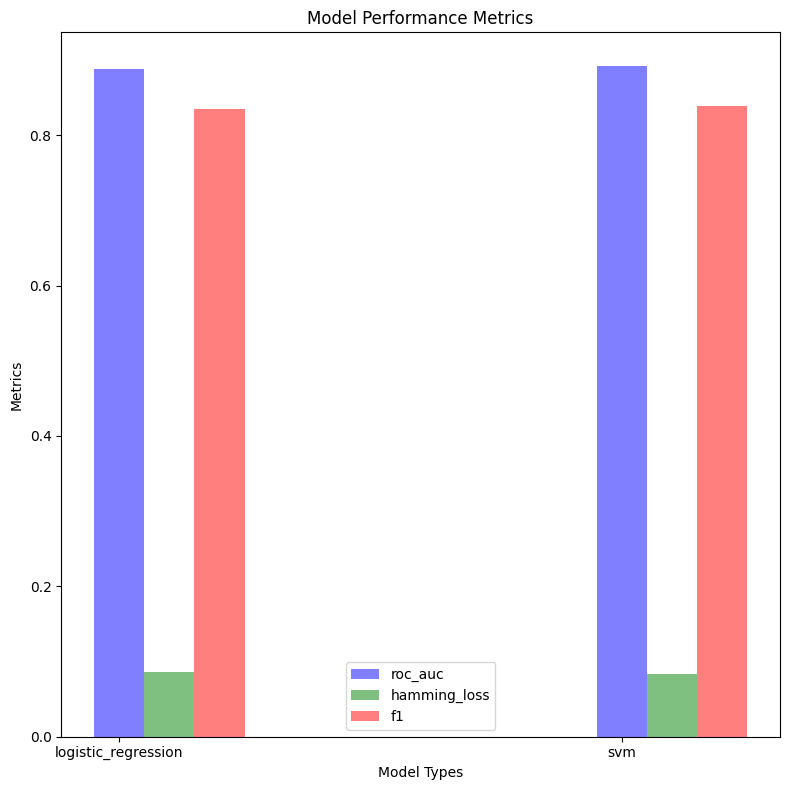

In [24]:
plot_metrics(metrics_dict, model_types)

In [25]:
# use the trained models for making predictions on different review sentences
review_sentences = ["This restaurant has amazing food and great service, as well as high price",
                    "This place is cozy and inviting, but the food is mediocre",
                    "Lively area",
                    "staff is horrible",
                    "The flavors of the dishes were exceptional, but the prices were a bit steep, then surrounding area of hotel is welcoming"]

for model_type, _model in trained_models.items():
    print(f"\nPredictions using {model_type}:")
    for review_sentence in review_sentences:
        # Tokenization and Encoding
        encoded_review = tokenizer.encode(review_sentence, add_special_tokens=True, return_tensors='pt')

        # Obtain DistilBERT Embeddings
        with torch.no_grad():
            embeddings = model(encoded_review)[0]

        # Predict Implicit Features
        predictions = _model.predict(embeddings)
        print(f"\nReview: {review_sentence}")
        print(f"Prediction: {predictions}")
        # Interpret Predictions
        # Assuming pred is the prediction vector
        for index, probability in enumerate(predictions[0]):
            if probability > 0:
                category_name = [key for key, value in feature_mapping.items() if value == index][0]
                print(f"Predicted Category: {category_name}")



Predictions using logistic_regression:

Review: This restaurant has amazing food and great service, as well as high price
Prediction: [[1 1 1 0 0]]
Predicted Category: food
Predicted Category: service
Predicted Category: price

Review: This place is cozy and inviting, but the food is mediocre
Prediction: [[1 0 0 1 0]]
Predicted Category: food
Predicted Category: ambience

Review: Lively area
Prediction: [[0 0 0 1 0]]
Predicted Category: ambience

Review: staff is horrible
Prediction: [[0 1 0 0 0]]
Predicted Category: service

Review: The flavors of the dishes were exceptional, but the prices were a bit steep, then surrounding area of hotel is welcoming
Prediction: [[1 0 1 1 0]]
Predicted Category: food
Predicted Category: price
Predicted Category: ambience

Predictions using svm:

Review: This restaurant has amazing food and great service, as well as high price
Prediction: [[1 1 1 0 0]]
Predicted Category: food
Predicted Category: service
Predicted Category: price

Review: This place 